In [5]:
using LinearAlgebra
using CairoMakie
using CurveFit

In [15]:
function plot_graph(M_list::Vector{Int}, errors::Vector{Float64}, expected_gradient::Int, plot_name::String)
    fontsize = 24
    
    expected_curve(x) = 1/x^expected_gradient
    ideal_curve = expected_curve.(M_list)

    # Calculate the slope of log-log values to check for second order convergence.
    fit = linear_fit(log.(M_list), log.(errors))
    slope = round(fit[2]; digits=4)

    fig = Figure(size = (900, 600), figure_padding = 10)
    ax = Axis(fig[1, 1], xscale=log10, yscale=log10, xlabel="Discretisation Size (log M)", ylabel="Global Error (log(Weighted 2-Norm))")
    
    scatterlines!(ax, M_list, errors, label="log(Global Error) (Slope = $slope)")
    scatterlines!(ax, M_list, ideal_curve, linestyle=:dash, label="Expected Gradient (Slope = -2)")
    
    ax.xlabelsize = fontsize
    ax.xticklabelsize = fontsize
    ax.yticklabelsize = fontsize
    ax.ylabelsize = fontsize

    axislegend(position = :rt, labelsize=fontsize)

    display(fig)

    save(plot_name, fig)
end

plot_graph (generic function with 1 method)

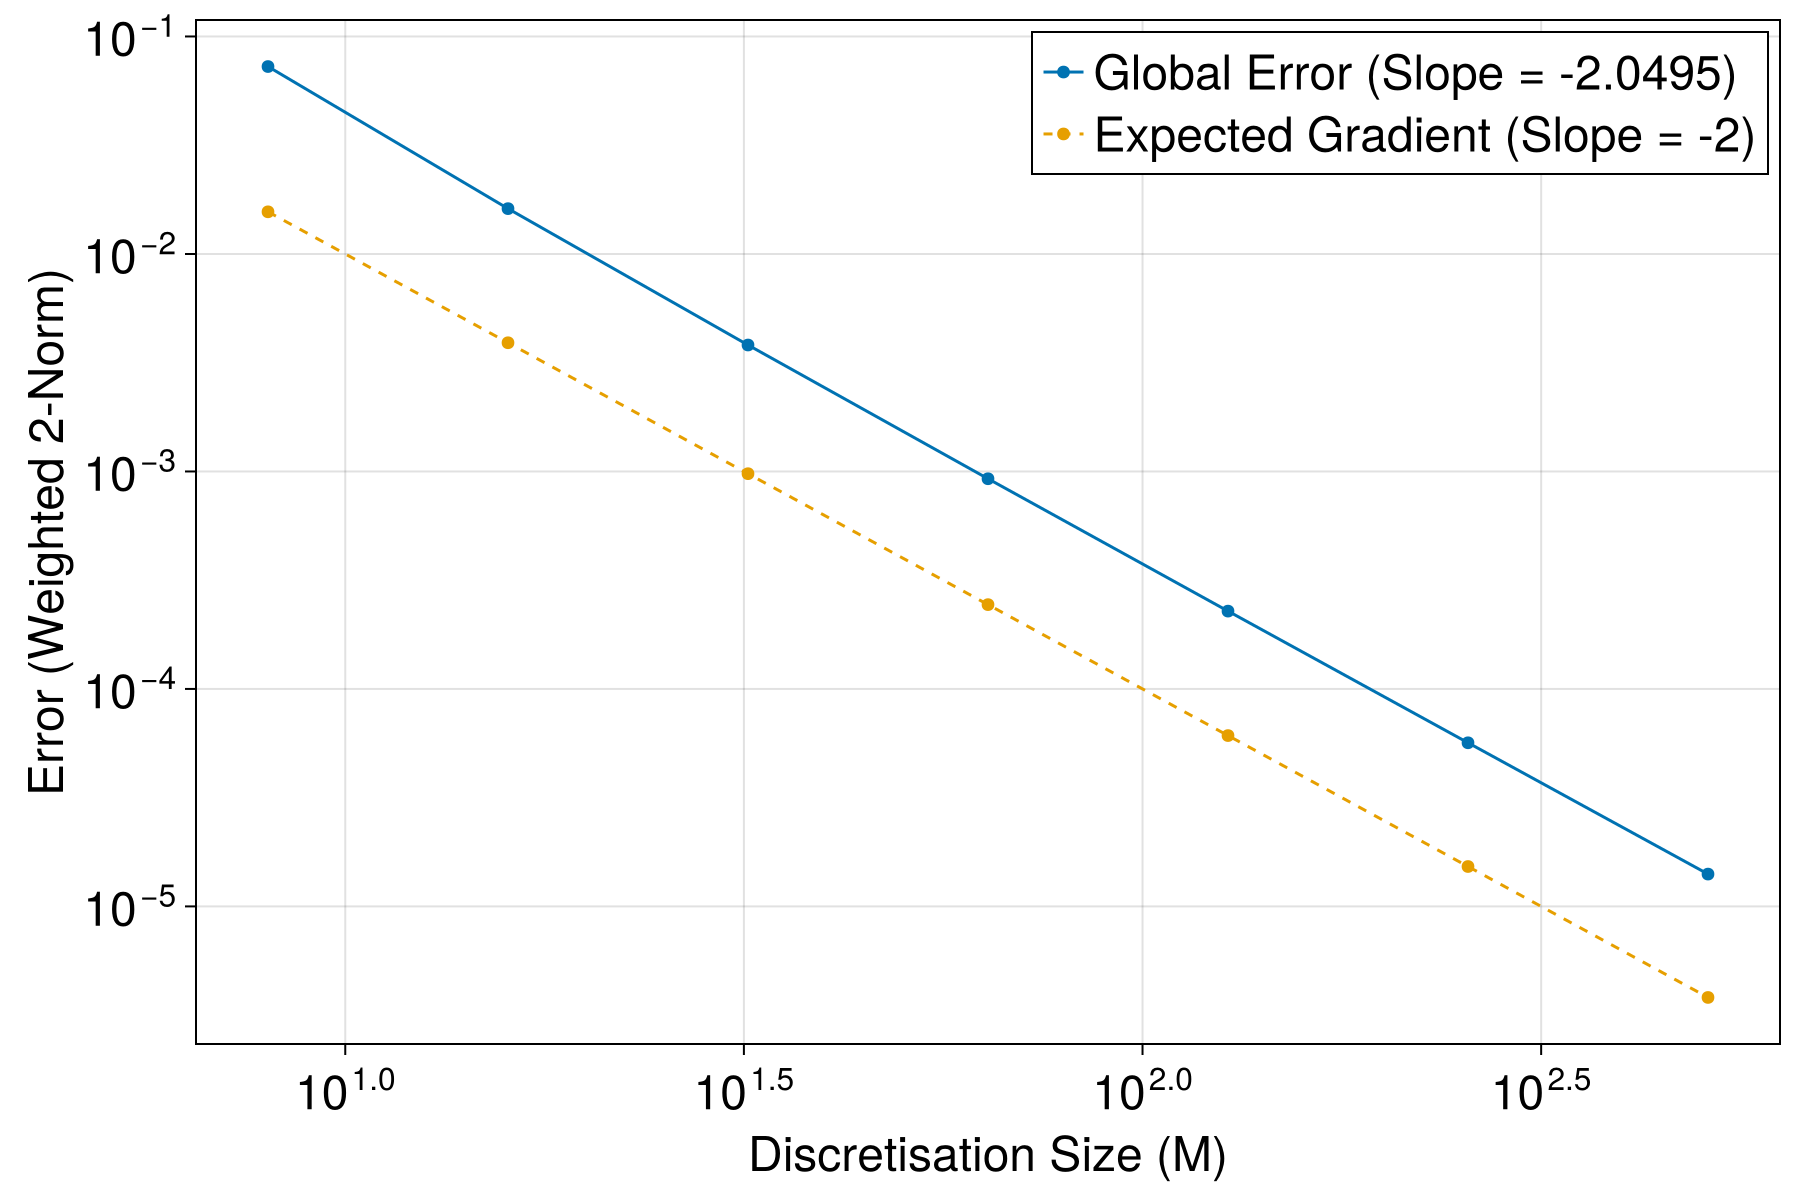

CairoMakie.Screen{IMAGE}


In [13]:
include("../../src/schemes/laplacian.jl")

function test_helmholtz()
    inflate(f, xs, ys) = [f(x,y) for x in xs, y in ys]
        
    x_0 = 0
    x_1 = 3
    y_0 = 0
    y_1 = 3
    Lx = x_1 - x_0
    Ly = y_1 - y_0

    alpha = -3.0
    u(x, y) = sin(2pi * (x) / Lx) * cos(2pi * (y) / Ly)

    # Uxx + Uyy - 3u = f(x, y)
    f(x, y) = -(pi^2)*(u(x,y)*(4/Ly^2 + 4/Lx^2)) + alpha*u(x, y)

    M_list = [8, 16, 32, 64, 128, 256, 512]
    errors = zeros(size(M_list)[1])

    for (i, M) in enumerate(M_list)
        P = M
        dx = Lx / M

        xs = range(x_0 - dx, x_1, length=M+2)
        ys = range(y_0 - dx, y_1, length=P+2)
        b = inflate(f, xs, ys)
        
        u_num = sp_solve_modified_helmholtz(M, P, dx, b, alpha)
        u_true = inflate(u, xs, ys)

        # Weighted 2-norm.
        errors[i] = dx * norm(u_num - u_true)
    end

    plot_graph(M_list, errors, 2, "../../plots/laplacian_validation.png")
end

test_helmholtz()

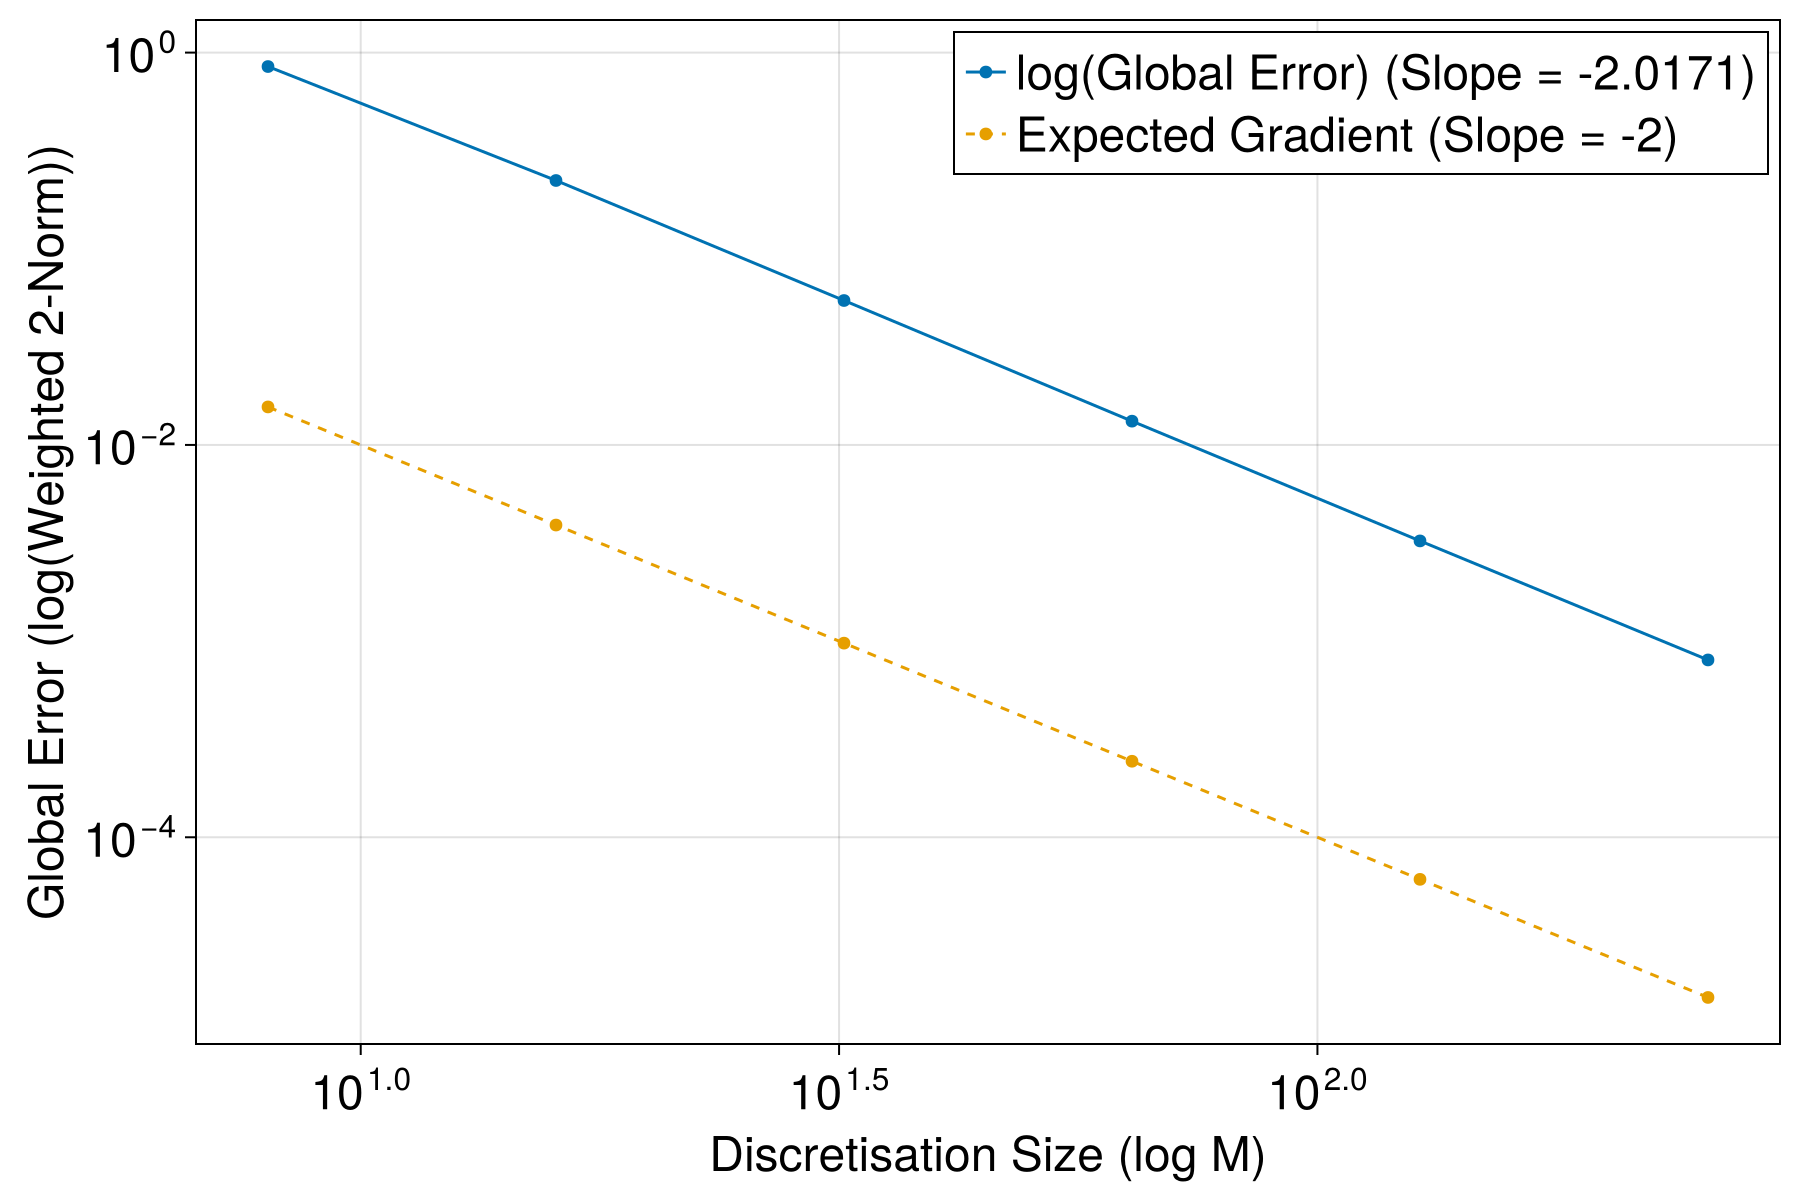

CairoMakie.Screen{IMAGE}


In [16]:
include("../../src/schemes/arakawa.jl")

function test_arakawa()
    Lx = 10
    Ly = 10
    A_func(x, y) = sin(2pi*x/Lx)*sin(2pi*y/Ly)
    B_func(x, y) = cos(2pi*x/Lx)*cos(2pi*y/Ly) 
    true_J_func(x, y) = -4pi^2/(Lx*Ly)*cos(2pi*x/Lx)^2*sin(2pi*y/Ly)^2 + 4pi^2/(Lx*Ly)*sin(2pi*x/Lx)^2*cos(2pi*y/Ly)^2 
    
    M_list = [8, 16, 32, 64, 128, 256]
    errors = zeros(size(M_list)[1])

    for (i, M) in enumerate(M_list)
        dx = Lx / M
        P = M

        xs = range(-dx, Lx, length=M+2)
        ys = range(-dx, Ly, length=P+2)
        A = Matrix{Float64}(inflate(A_func, xs, ys))
        B = Matrix{Float64}(inflate(B_func, xs, ys))

        true_J_matrix = inflate(true_J_func, xs, ys)
        test_J_matrix = J(dx, A, B)

        errors[i] = dx * norm(test_J_matrix - true_J_matrix)
    end

    plot_graph(M_list, errors, 2, "../../plots/arakawa_validation.png")
end

test_arakawa()